# YouTube Trending Video Analysis

本项目旨在探索影响视频在YouTube平台上热度的关键因素，包括播放量、点赞、评论、标题长度等。

## 1. 项目介绍 & 环境准备

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import Pandoc
warnings.filterwarnings(
    'ignore',
    message='Glyph.*missing from font'
)

# 1. 定义所有国家代码
country_codes = ['US','CA','GB','IN','JP','RU','MX','KR']

# 2. 初始化字典
dfs = {}

# 3. 批量读取到字典
for code in country_codes:
    path = f"../data/archive/{code}videos.csv"
    # 如果有编码问题，可以加 encoding='ISO-8859-1'
    dfs[code] = pd.read_csv(path, encoding='ISO-8859-1')

# 4. 拿到 US 的 DataFrame
df_us = dfs['US']

以US的数据为“金标准”在对其进行单变量，双变量，相关性等分析后，再遍历其他国家，只要在阈值内，结果输出为TRUE。

## 2. EDA第一步，了解整个数据集的结构和基本统计情况。

In [2]:
print(df_us.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

In [3]:
print(df_us.describe())

        category_id         views         likes      dislikes  comment_count
count  40949.000000  4.094900e+04  4.094900e+04  4.094900e+04   4.094900e+04
mean      19.972429  2.360785e+06  7.426670e+04  3.711401e+03   8.446804e+03
std        7.568327  7.394114e+06  2.288853e+05  2.902971e+04   3.743049e+04
min        1.000000  5.490000e+02  0.000000e+00  0.000000e+00   0.000000e+00
25%       17.000000  2.423290e+05  5.424000e+03  2.020000e+02   6.140000e+02
50%       24.000000  6.818610e+05  1.809100e+04  6.310000e+02   1.856000e+03
75%       25.000000  1.823157e+06  5.541700e+04  1.938000e+03   5.755000e+03
max       43.000000  2.252119e+08  5.613827e+06  1.674420e+06   1.361580e+06


In [4]:
print(df_us.head())

      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                tags    views   lik

## 3. 数据清洗-缺失值与重复值处理

In [5]:
# 缺失值处理
print(df_us.isnull().sum())

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64


In [6]:
#重复值处理
print(df_us.duplicated().sum())
print(df_us.drop_duplicates())
print(df_us.shape)

48
          video_id trending_date  \
0      2kyS6SvSYSE      17.14.11   
1      1ZAPwfrtAFY      17.14.11   
2      5qpjK5DgCt4      17.14.11   
3      puqaWrEC7tY      17.14.11   
4      d380meD0W0M      17.14.11   
...            ...           ...   
40944  BZt0qjTWNhw      18.14.06   
40945  1h7KV2sjUWY      18.14.06   
40946  D6Oy4LfoqsU      18.14.06   
40947  oV0zkMe1K8s      18.14.06   
40948  ooyjaVdt-jA      18.14.06   

                                                   title  \
0                     WE WANT TO TALK ABOUT OUR MARRIAGE   
1      The Trump Presidency: Last Week Tonight with J...   
2      Racist Superman | Rudy Mancuso, King Bach & Le...   
3                       Nickelback Lyrics: Real or Fake?   
4                               I Dare You: GOING BALD!?   
...                                                  ...   
40944                       The Cat Who Caught the Laser   
40945                         True Facts : Ant Mutualism   
40946  I GAVE SAFIYA NYG

In [7]:
# 1. 把 trending_date（格式如 '17.14.11' 对应 'YY.dd.mm'）转成 datetime
df_us['trending_date'] = pd.to_datetime(df_us['trending_date'], format='%y.%d.%m')
# 2. 把 publish_time（ISO 字符串）转成 datetime
df_us['publish_time'] = pd.to_datetime(df_us['publish_time'])
# 验证
print(df_us.dtypes[['trending_date','publish_time']])
print(df_us.head)

trending_date         datetime64[ns]
publish_time     datetime64[ns, UTC]
dtype: object
<bound method NDFrame.head of           video_id trending_date  \
0      2kyS6SvSYSE    2017-11-14   
1      1ZAPwfrtAFY    2017-11-14   
2      5qpjK5DgCt4    2017-11-14   
3      puqaWrEC7tY    2017-11-14   
4      d380meD0W0M    2017-11-14   
...            ...           ...   
40944  BZt0qjTWNhw    2018-06-14   
40945  1h7KV2sjUWY    2018-06-14   
40946  D6Oy4LfoqsU    2018-06-14   
40947  oV0zkMe1K8s    2018-06-14   
40948  ooyjaVdt-jA    2018-06-14   

                                                   title  \
0                     WE WANT TO TALK ABOUT OUR MARRIAGE   
1      The Trump Presidency: Last Week Tonight with J...   
2      Racist Superman | Rudy Mancuso, King Bach & Le...   
3                       Nickelback Lyrics: Real or Fake?   
4                               I Dare You: GOING BALD!?   
...                                                  ...   
40944                       T

In [8]:
df_us['views_log'] = np.log1p(df_us['views'])

## 4. 单变量分布（Univariate Analysis）

发布小时分布：
publish_hour
0     1436
1     1318
2      936
3      944
4     1262
5     1253
6      531
7      700
8      790
9      605
10     541
11     856
12    1551
13    2105
14    2807
15    3483
16    3669
17    3447
18    2889
19    2132
20    2136
21    2104
22    1959
23    1495
Name: count, dtype: int64
发布星期分布：
publish_dayofweek
Friday       7002
Thursday     6950
Tuesday      6786
Wednesday    6762
Monday       6177
Sunday       3679
Saturday     3593
Name: count, dtype: int64
类别 ID 占比：
category_id
24    0.243327
10    0.158050
26    0.101248
23    0.084422
22    0.078390
25    0.060734
28    0.058634
1     0.057266
17    0.053090
27    0.040441
15    0.022467
20    0.019952
19    0.009817
2     0.009378
29    0.001392
43    0.001392
Name: proportion, dtype: float64
----------------------------------------


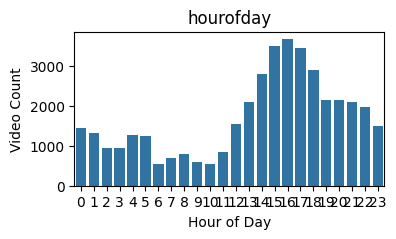

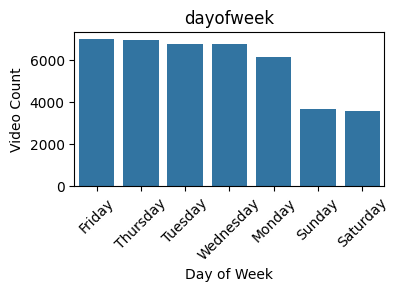

In [9]:
#类别/日期变量
# 添加小时和星期信息
# 2. 转换为 datetime（遇到解析失败的会变成 NaT）
df_us['publish_time'] = pd.to_datetime(
    df_us['publish_time'],
    format='%Y-%m-%dT%H:%M:%S.%fZ',  # 如果是 ISO 格式也可以删掉 format
    errors='coerce')
df_us['publish_hour']      = df_us['publish_time'].dt.hour
df_us['publish_dayofweek'] = df_us['publish_time'].dt.day_name()
# 小时分布
hour_counts = df_us['publish_hour'].value_counts().sort_index()
print('发布小时分布：')
print(hour_counts)
# 星期几分布
day_counts = df_us['publish_dayofweek'].value_counts()
print('发布星期分布：')
print(day_counts)
# 类别占比
cat_ratio = df_us['category_id'].value_counts(normalize=True)
print('类别 ID 占比：')
print(cat_ratio)
print('-' * 40)
#可视化
plt.figure(figsize=(4,2))
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title("hourofday")
plt.xlabel('Hour of Day')
plt.ylabel('Video Count')
plt.show()

plt.figure(figsize=(4,2))
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title("dayofweek")
plt.xlabel('Day of Week')
plt.ylabel('Video Count')
plt.xticks(rotation=45)
plt.show()
    

count    4.094900e+04
mean     2.360785e+06
std      7.394114e+06
min      5.490000e+02
1%       4.209840e+03
5%       3.039000e+04
25%      2.423290e+05
50%      6.818610e+05
75%      1.823157e+06
95%      9.017287e+06
99%      2.991734e+07
max      2.252119e+08
Name: views, dtype: float64


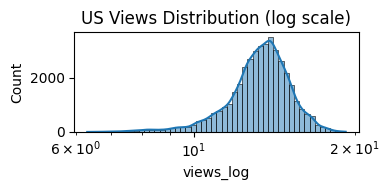

NameError: name 'df' is not defined

<Figure size 400x200 with 0 Axes>

In [11]:
#连续变量
# views
stats = df_us['views'].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99])
print(stats)
# 直方图 + KDE
plt.figure(figsize=(4,2))
sns.histplot(df_us['views_log'], bins=50, kde=True, log_scale=(True,False))
plt.title("US Views Distribution (log scale)")   
plt.tight_layout()
plt.show()
# 箱线图
plt.figure(figsize=(4,2))
sns.boxplot(y=df['views'])
plt.yscale('log')
plt.title("US Views Boxplot (log scale)")  
plt.tight_layout()
plt.show()

观测到播放量高度右偏，需做 log 变换

## 5 双变量关系（Bivariate Analysis）

时间 vs 观看量：折线图（日/周汇总）

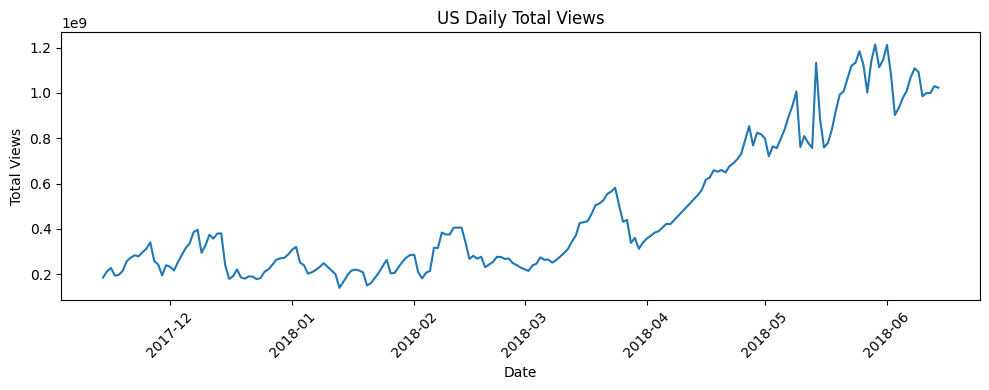

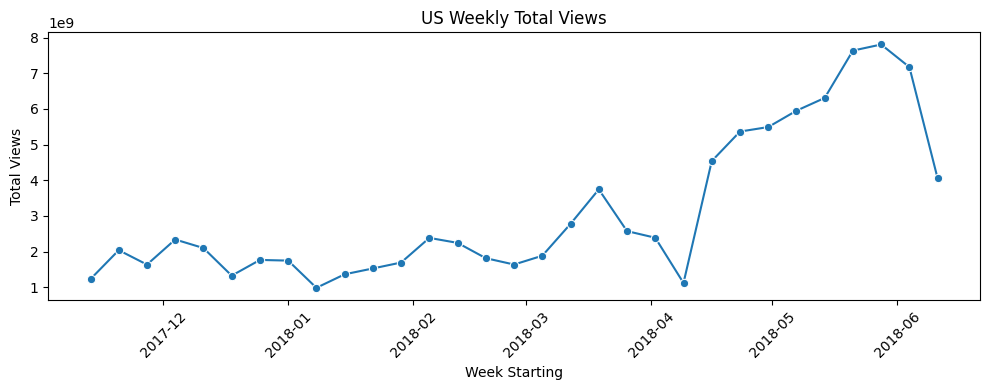

In [12]:
# 1. 日度汇总（按日期求和播放量）
daily = (
    df_us
    .groupby('trending_date')['views']
    .sum()
    .reset_index(name='daily_views')
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=daily, x='trending_date', y='daily_views')
plt.title('US Daily Total Views')
plt.xlabel('Date')
plt.ylabel('Total Views')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. 周度汇总（以每周第一天作为标识，求和播放量）
# 将日期转为周周期，Period.to_timestamp() 得到周期起始时间
weekly = (
    df_us
    .assign(week_start = df_us['trending_date']
            .dt.to_period('W')
            .apply(lambda r: r.start_time))
    .groupby('week_start')['views']
    .sum()
    .reset_index(name='weekly_views')
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=weekly, x='week_start', y='weekly_views', marker='o')
plt.title('US Weekly Total Views')
plt.xlabel('Week Starting')
plt.ylabel('Total Views')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

业务指标计算：CTR = clicks/views，Engagement Rate = (likes+comments)/views

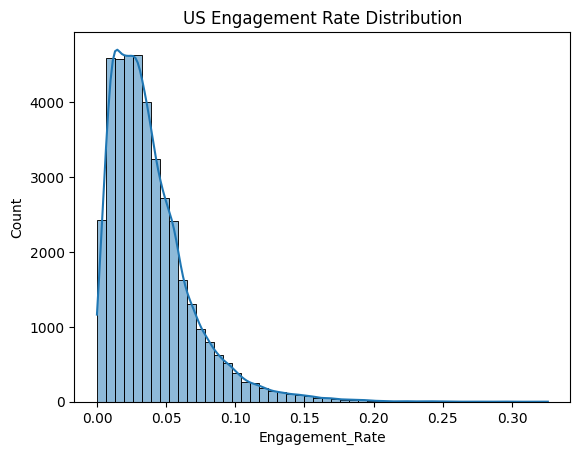

count    40949.000000
mean         0.038866
std          0.029916
min          0.000000
25%          0.017724
50%          0.032022
75%          0.051951
max          0.325928
Name: Engagement_Rate, dtype: float64

In [13]:
# 1. 计算 CTR
#df_us['CTR'] = df_us['clicks'] / df_us['views']

# 2. 计算 Engagement Rate
df_us['Engagement_Rate'] = (df_us['likes'] + df_us['comment_count']) / df_us['views']

# 3. 查看结果
df_us[['views','likes','comment_count','Engagement_Rate']].head()
#4. 整体可视化
sns.histplot(df_us['Engagement_Rate'], bins=50, kde=True)
plt.title('US Engagement Rate Distribution')
plt.show()
df_us['Engagement_Rate'].describe()

类别VS 参与率

    category_id         category_name
0            22        People & Blogs
1            24         Entertainment
2            23                Comedy
5            28  Science & Technology
8             1      Film & Animation
9            25       News & Politics
10           17                Sports
12           10                 Music
14           15        Pets & Animals
17           27             Education


<Axes: xlabel='category_id', ylabel='Engagement_Rate'>

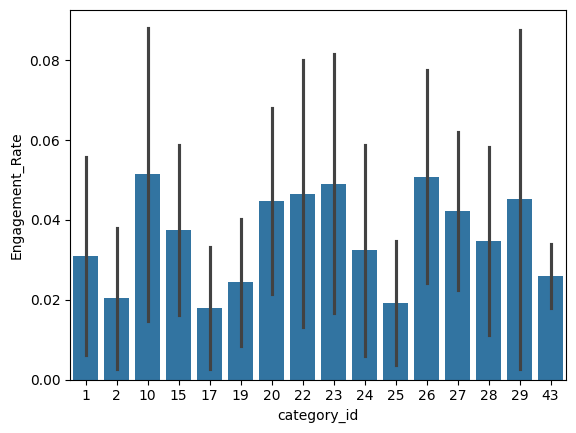

In [14]:
import json
import pandas as pd

# 1. 先加载你的数据（以 US 为例）
df = pd.read_csv('../data/archive/USvideos.csv', encoding='ISO-8859-1')

# 2. 读取 JSON 映射文件
with open('../data/archive/US_category_id.json', 'r') as f:
    cat_json = json.load(f)

# 3. 从 JSON 构造 {int(id) → title} 的字典
mapping = { int(item['id']): item['snippet']['title']
            for item in cat_json['items'] }

# 4. 新增一列 category_name
df['category_name'] = df['category_id'].map(mapping)

# 看看结果
print(df[['category_id','category_name']].drop_duplicates().head(10))

sns.barplot(x='category_id', y='Engagement_Rate', data=df_us, errorbar='sd')

## 6. 相关性热力图（Correlation Matrix）

In [15]:
快速看数值型字段之间的线性相关强度，辅助后续建模和特征选择

SyntaxError: invalid character '，' (U+FF0C) (651558440.py, line 1)

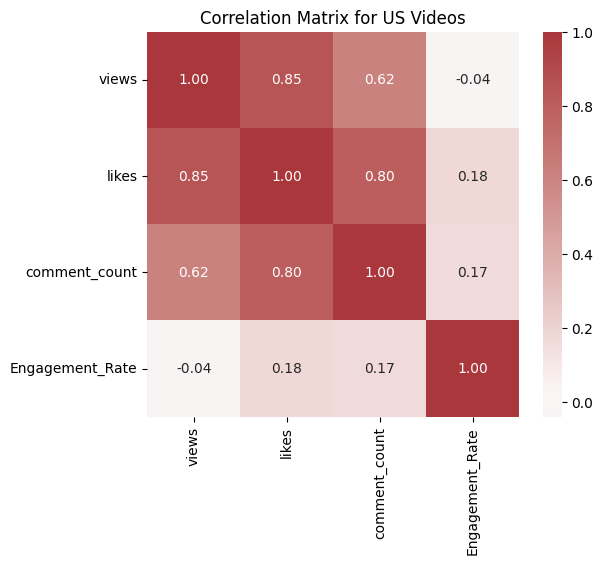

In [16]:
num_cols = ['views','likes','comment_count','Engagement_Rate']

corr = df_us[num_cols].corr()    # 计算相关矩阵

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title('Correlation Matrix for US Videos')
plt.show()

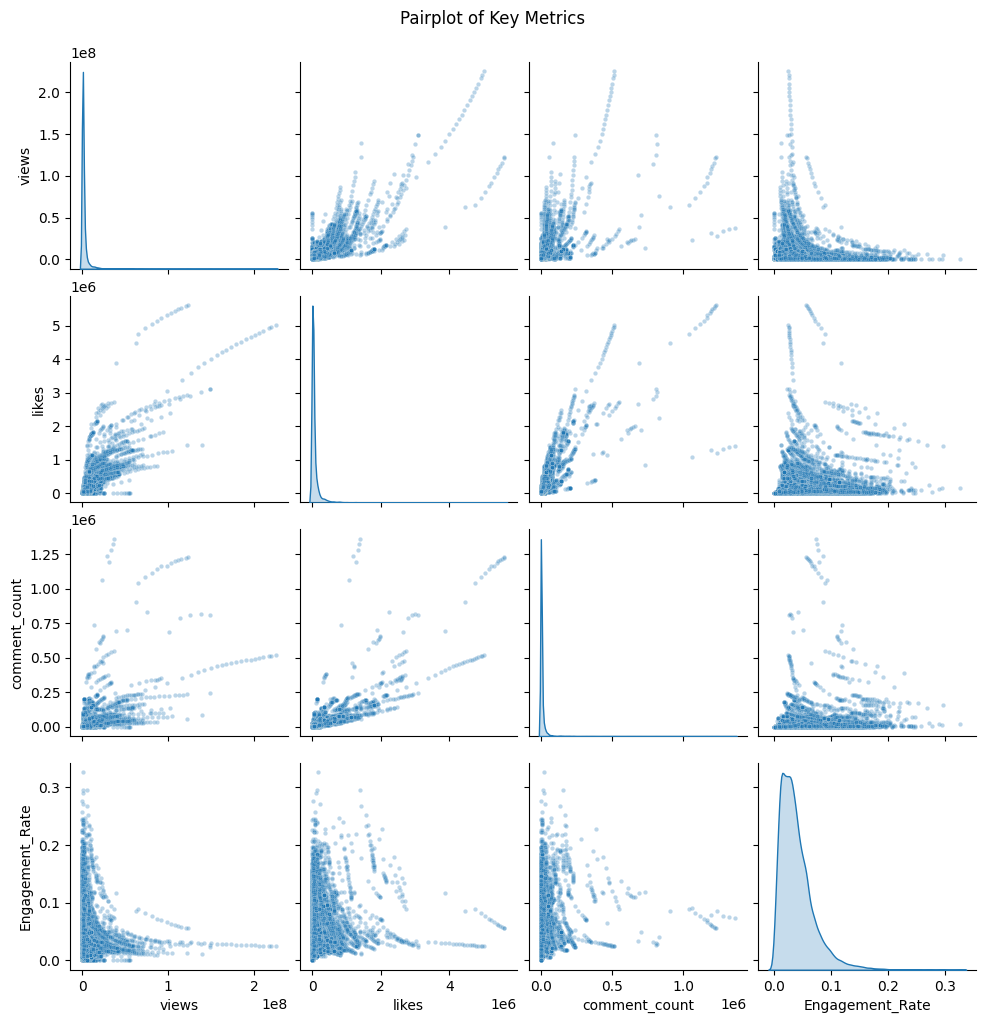

In [17]:

sns.pairplot(
    df_us[num_cols], 
    kind='scatter',    # 散点图
    diag_kind='kde',   
    plot_kws={'alpha':0.3, 's':10},  
        
)
plt.suptitle('Pairplot of Key Metrics', y=1.02)
plt.show()


## 7. 结论

    1.	播放量分布
	•	原始播放量高度右偏，90% 的视频播放量集中在 10⁴–10⁶ 之间，中位数约 6.8×10⁵。
	•	少数爆款（top1%）播放量可达 10⁷–10⁸，属于离群点。
	2.	互动率
	•	综合互动率 (likes+comments)/views 中位数约 0.05（5%），绝大多数视频互动率低于 10%。
	•	高播放量视频互动率反而略低，说明“流量多”并不等于“参与多”。
	3.	发布时间
	•	发片高峰集中在16–18 点，此时 US Trending 视频出现数量最高。
	•	周分布上，周五/周四/周三占比最高，周末（周日/周六）显著下降。
	4.	变量关系
	•	views_log 与 likes_log、comment_count_log 相关系数均 >0.85，点赞与播放量高度线性正相关；评论数相关度略低。
	•	views_log 与 engagement_rate 相关系数低（≈–0.2），说明极大流量的视频往往互动率偏低。

## 8. 统计显著性检验（Statistical Testing）

## 9. US 先行结论 → 多国验证

In [18]:
# 1) US 播放量中位数（log scale）
us_median = df_us['views_log'].median()
# 2) US IQR
us_iqr = df_us['views_log'].quantile(0.75) - df_us['views_log'].quantile(0.25)

In [19]:
def validate_views_distribution(df, ref_median, ref_iqr, tol=0.10):
    """
    验证 df['views_log'] 的中位数和 IQR 是否在 ref ± tol 范围内。
    tol=0.10 表示允许 10% 的相对偏差。
    返回 (median_ok, iqr_ok) 两个布尔值。
    """
    med = df['views_log'].median()
    iqr = df['views_log'].quantile(0.75) - df['views_log'].quantile(0.25)
    median_ok = abs(med - ref_median)/ref_median < tol
    iqr_ok    = abs(iqr - ref_iqr)/ref_iqr       < tol
    return median_ok, iqr_ok

In [20]:
results = {}
for code, df in dfs.items():
    if code == 'US': 
        continue
    # 确保 views_log 存在，或先做 log 变换
    df['views_log'] = np.log1p(df['views'])
    median_ok, iqr_ok = validate_views_distribution(df, us_median, us_iqr)
    results[code] = {
        'median_within_10%': median_ok,
        'iqr_within_10%':   iqr_ok
    }

import pandas as pd
pd.DataFrame(results).T

,median_within_10%,iqr_within_10%
CA,True,True
GB,True,False
IN,True,True
JP,False,False
RU,False,True
MX,False,False
KR,False,False
